# Exercise 1: Linear Image Classifier

In this exercise you will implement a linear image classifier while getting familiar with `numpy` and the benefits of vectorized operations in Python. This exercise has 3 parts:

1. Python warmup: working with images, refresher on classes and objects.
2. Implementing loss functions, calculating gradients and implementing gradient descent.
3. Training and evaluating several classifiers.

## Submission guidelines:

Your zip should include the following files only:
```
- HW1.ipynb
- functions/
    - classifier.py
    - losses.py
```
Name the file `ex1_ID.zip` and do **not** include any additional directories or the data. 

## Read the following instructions carefully:

1. This jupyter notebook contains all the step by step instructions needed for this exercise.
2. Write **efficient vectorized** code whenever instructed. 
3. You are responsible for the correctness of your code and should add as many tests as you see fit. Tests will not be graded nor checked.
4. Do not change the functions we provided you. 
4. Write your functions in the instructed python modules only. All the logic you write is imported and used using this jupyter notebook. You are allowed to add functions as long as they are located in the python modules and are imported properly.
5. You are allowed to use functions and methods from the [Python Standard Library](https://docs.python.org/3/library/) and [numpy](https://www.numpy.org/devdocs/reference/) only. Any other imports are forbidden.
6. Your code must run without errors. Use `python 3` and `numpy 1.15.4` (configure a new environment as shown in the 2nd lecture if needed). Changes of the configuration we provided are at your own risk. Before submitting the exercise, restart the kernel and run the notebook from start to finish to make sure everything works. **Code that cannot run will not be tested.**
7. Write your own code. Cheating will not be tolerated. 
8. Answers to qualitative questions should be written in **markdown** cells (with $\LaTeX$ support).

Q: What archive file format should you be using to compress the files and upload them to Moodle?

A: *.zip

Q: Should you run your code and make sure everything works just before you **zip** the files for submission? What will happen if your code cannot run?

A: you will tell me and ill fix

Q: Should you include the data in your submission?

A: no

In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt
from functions.classifier import LinearPerceptron
from functions.classifier import LogisticRegression
from functions.losses import perceptron_loss_vectorized
from functions.losses import perceptron_loss_naive
from functions.losses import binary_cross_entropy
from functions.losses import grad_check

# specify the way plots behave in jupyter notebook
%matplotlib inline
plt.rcParams['figure.figsize'] = (8.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# auto-reloading extenrnal modules
%load_ext autoreload
%autoreload 2

In [4]:
import platform
print("Python version: ", platform.python_version())
print("Numpy version: ", np.__version__)

Python version:  3.7.1
Numpy version:  1.15.4


## Data preprocessing
The next few cells will download and extract CIFAR-10 into `datasets/cifar10/`. The CIFAR-10 dataset consists of 60,000 32x32 color images in 10 classes, with 6,000 images per class. There are 50,000 training images and 10,000 test images. The dataset is divided into five training batches and one test batch, each with 10,000 images. The test batch contains exactly 1,000 randomly-selected images from each class.

We have included several image processing functions. Notice the following in particular: we created an additional validation dataset you need to use for hyperparameter optimization (learning rate and L2 regularization). We subtracted the mean from all the images in order to ignore illumination conditions while keeping the content of the image. Next, we flattened the images from a tensor of shape (32x32x3) to a vector with 3072 features (pixel values) so we would be able to use a simple matrix multiplication. Finally, we concatenated each image vector with an additional feature to account for the bias. This is known as the bias trick. 

Make sure you understand this image processing pipeline before diving into the rest of the code.

In [1]:
from datasets import load_cifar10
URL = "https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz"
PATH = 'datasets/cifar10/' # the script will create required directories
load_cifar10.maybe_download_and_extract(URL, PATH)

- Download progress: 100.0%
Download finished. Extracting files.
Done.


In [6]:
CIFAR10_PATH = os.path.join(PATH, 'cifar-10-batches-py')
X_train, y_train, X_test, y_test = load_cifar10.load(CIFAR10_PATH) # load the entire data

# taking only two classes from the dataset
X_train = X_train[np.logical_or(y_train == 0, y_train == 1)]
y_train = y_train[np.logical_or(y_train == 0, y_train == 1)]
X_test = X_test[np.logical_or(y_test == 0, y_test == 1)]
y_test = y_test[np.logical_or(y_test == 0, y_test == 1)]

# define a splitting for the data
num_training = 10000
num_validation = 1000
num_testing = 1000

# add a validation dataset for hyperparameter optimization
mask = range(num_training)
X_train = X_train[mask]
y_train = y_train[mask]
mask = range(num_validation)
X_val = X_test[mask]
y_val = y_test[mask]
mask = range(num_validation, num_validation+num_testing)
X_test = X_test[mask]
y_test = y_test[mask]

# float64
X_train = X_train.astype(np.float64)
X_val = X_val.astype(np.float64)
X_test = X_test.astype(np.float64)

# subtract the mean from all the images in the batch
mean_image = np.mean(X_train, axis=0)
X_train -= mean_image
X_val -= mean_image
X_test -= mean_image

# flatten all the images in the batch (make sure you understand why this is needed)
X_train = np.reshape(X_train, newshape=(X_train.shape[0], -1))
X_val = np.reshape(X_val, newshape=(X_val.shape[0], -1)) 
X_test = np.reshape(X_test, newshape=(X_test.shape[0], -1)) 

# add a bias term to all images in the batch
X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))]) 
X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))]) 
X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))]) 

print(X_train.shape)
print(X_val.shape)
print(X_test.shape)
classes = ('plane', 'car')

(10000, 3073)
(1000, 3073)
(1000, 3073)


          car           car         plane         plane


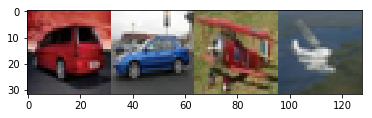

In [7]:
def get_batch(X, y, n):
    rand_items = np.random.randint(0, X.shape[0], size=n)
    images = X[rand_items]
    labels = y[rand_items]
    return X, y

def make_random_grid(x, y, n=4):
    rand_items = np.random.randint(0, x.shape[0], size=n)
    images = x[rand_items]
    labels = y[rand_items]
    grid = np.hstack((np.asarray((vec_2_img(i) + mean_image), dtype=np.int) for i in images))
    print(' '.join('%13s' % classes[labels[j]] for j in range(4)))
    return grid

def vec_2_img(x):
    x = np.reshape(x[:-1], (32, 32, 3))
    return x

X_batch, y_batch = get_batch(X_test, y_test, 4)
plt.imshow(make_random_grid(X_batch, y_batch));

## Linear classifier: mapping images to scores

During this exercise, we will maintain a python class with basic functionality (such as training the model). the linear classifiers we will build (perceptron, logistic regression) will inherit some functionality from that class and will change several functions (such as the loss function, for example). Open the file `functions/classifier.py` and make sure you understand the code. You might find this [short classes in python tutorial](https://www.hackerearth.com/practice/python/object-oriented-programming/classes-and-objects-i/tutorial/) useful.

## Linear perceptron
Our first linear classifier will include a linear function that maps images to scores:

$$
f(x_i; W, b) = W\cdot x_i + b
$$

As you learned in class, this linear classifier takes an input image $x_i$ and outputs a class score. Your goal is to **learn** the parameters $W$ and $b$ to best classify the images according to the provided labels. The linear perceptron is set up so that the perceptron learn to map the correct class for each image such that it will have a score higher than the incorrect class. In this exercise, we will define our Linear perceptron to have two outputs - one outputs for each class.      

Open the file `functions/classifier.py`. The constructor of the `LinearPerceptron` class takes as input the dataset and labels in order to create appropriate parameters. Notice we are using the bias trick and only use the matrix `w` for convenience. Since we already have a (random) model, we can start predicting classes on images. Complete the method `predict` in the `LinearPerceptron` class. **(2.5 points)**

In [36]:
classifier = LinearPerceptron(X_train, y_train)
y_pred = classifier.predict(X_test)

[0.8951200387168425, -0.40745057586114974, -0.041606082505145636, 0.9299406012762328, 0.7113100603509506, -0.4857790403794908, -0.34917965834387643, 0.962115067761445, -0.9850950727810095, -0.42828917286939583, -0.5097419355391215, -0.8571709524383513, -0.5503691654855845, 0.3954725575659108, 0.437584866442974, -0.8502054651228821, -0.9760638050548289, 0.488345518270628, 0.16831054944756763, -0.06840245409173362, -0.5463962694928497, -0.07369384785235944, 0.7402599112572101, -0.7486865116224009, 0.3630192765024447, 0.9849663939634006, 0.6517603946931532, -0.5339732492333318, -0.10045011785668345, -0.06175390928555613, -0.4239331651172944, -0.42996393537326094, 0.607309274359334, 0.7741293070014377, -0.5766897770304431, -0.7580359470525291, 0.9299490482692818, -0.10293190541404584, 0.402908911892107, -0.23861959720527293, 0.7316607651624709, 0.1696862021024328, 0.6938279032241081, 0.84141517822684, 0.32933202272978557, 0.4572089312774261, 0.7795951893510413, 0.8755200132835967, -0.67648

TypeError: can only concatenate list (not "float") to list

        plane           car           car           car


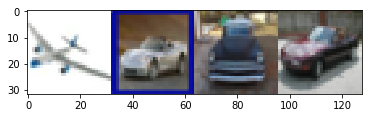

In [34]:
X_batch, y_batch = get_batch(X_train, y_train, 4)
plt.imshow(make_random_grid(X_batch, y_batch));

In [32]:
# predictions
print(' '.join('%13s' % classes[y_pred[j]] for j in range(4)))

IndexError: list index out of range

## Evaluation

Complete the class method `calc_accuracy` in `functions/classifier.py`. Explain why the accuracy on the training dataset (remember, the model is not trained yet) is around 50%. **(2.5 points)**

In [ ]:
print("model accuracy: ", classifier.calc_accuracy(X_train, y_train))

Your answer here:

## Hinge loss (30 points)

Your code for this section will all be written inside `functions/losses.py`. In this section, we write and test code outside the classes for convenience. Notice the loss method for each class is just a call for the loss function written in `losses.py`. Once you are finished with implementation, everything should work.

First, complete the function `perceptron_loss_naive`. This function takes as input the weights, data, labels and a regularization term and outputs the calculated loss as a single number and the gradients with respect to W.

In [ ]:
W = np.random.randn(3073, 2) * 0.0001

In [ ]:
%%time
loss_naive, grad_naive = perceptron_loss_naive(W, X_val, y_val)
print ('loss: %f' % (loss_naive, ))

You are provided with a gradient checking function called `grad_check` in `functions/losses.py`. The following cells test your implementation of the loss value and gradient. Errors should be below $10^{-8}$.

In [ ]:
loss, grad = perceptron_loss_naive(W, X_val, y_val)
f = lambda w: perceptron_loss_naive(w, X_val, y_val)[0]
grad_numerical = grad_check(f, W, grad)

Once your code works, complete the function `perceptron_loss_vectorized` and compare the results of the two functions using the cell below.

In [ ]:
%%time

loss_vectorized, grad_vectorized = perceptron_loss_vectorized(W, X_val, y_val)
print ('loss: %f' % (loss, ))

difference = np.linalg.norm(grad_naive - grad_vectorized)
print ('difference: %f' % difference)

We have obtained an efficient function for loss and gradient calculation and we can now train our network. Complete the function `train` in `functions/classifier.py`. This function should be implemented in the `LinearClassifier` class. (**10 points**)

In [ ]:
%%time
perceptron = LinearPerceptron(X_train, y_train)
loss_history = perceptron.train(X_train, y_train, 
                         learning_rate=1e-7,
                         num_iters=1500,
                         verbose=True)

In [ ]:
plt.plot(loss_history)
plt.xlabel('Iteration number')
plt.ylabel('Loss value')
plt.show()

In [ ]:
print("Training accuracy: ", perceptron.calc_accuracy(X_train, y_train))
print("Testing accuracy: ", perceptron.calc_accuracy(X_test, y_test))

## Hyperparameter optimization

Your model should have improved from 50% accuracy to ~75% accuracy in a matter of seconds. Now, use the validation set to tune hyperparameters by training different models (using the training dataset) and evaluating the performance using the validation dataset. Save the results in a dictionary mapping tuples of the form `(learning_rate, batch_size)` to tuples of the form `(training_accuracy, validation_accuracy)`. Finally, you should evaluate the best model on the testing dataset. 

Note: When changing the batch_size, change the number of iterations accordingly such that the number of epochs on the data stays roughly the same. A reasonable ratio is 600 iterations for a batch size of 200. 

If you are carful you should reach ~83% accuracy on the validation dataset.

Use a small value for the number of iterations as you develop your code. Once you are confident that everything works, run it again for more iterations. Finally, explain the results - what can you learn from the hyper parameters that yields the best results? Why do you think that is the case? **(5 points)**

In [ ]:
# You are encouraged to experiment with additional values
learning_rates = [1e-7, 5e-6]
batch_sizes = [1, 100, 200, 500, 10000]

results = {}
best_val = -1   # The highest validation accuracy that we have seen so far.
best_perceptron = None # The LinearPerceptron object that achieved the highest validation rate.

################################################################################
#                            START OF YOUR CODE                                #
################################################################################
pass
################################################################################
#                              END OF YOUR CODE                                #
################################################################################
    
# Print out results.
for lr, batch_size in sorted(results):
    train_accuracy, val_accuracy = results[(lr, batch_size)]
    print ('lr %e batch_size %e train accuracy: %f val accuracy: %f' % (
                lr, batch_size, train_accuracy, val_accuracy))
    
print ('best validation accuracy achieved during cross-validation: %f' % best_val)

test_accuracy = best_perceptron.calc_accuracy(X_test, y_test)
print ('linear perceptron on raw pixels final test set accuracy: %f' % test_accuracy)

In [ ]:
w = best_perceptron.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 2)
w_min, w_max = np.min(w), np.max(w)
classes = ['plane', 'car']
for i in range(2):
    plt.subplot(1, 2, i + 1)
    # Rescale the weights to be between 0 and 255
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])

## Logistic regression

Another choice for a binary classifier is the binary logistic regression classifier. Unlike the perceptron which treats the outputs as uncalibrated and possibly difficult to interpret scores for each class, the binary logistic regression classifier gives a slightly more intuitive output in the form of normalized class probabilities. In this classifier, the function mapping $f(x_i; W, b) = W\cdot x_i + b$ stays unchanged but we now interpret these scores as the unnormalized log probabilities for each class and replace the hinge loss with a cross-entropy loss. In this exercise, we will define our binary logistic regression classifier to have one input.       

Open the file `functions/classifier.py`. The constructor of the `LogisticRegression` class takes as input the dataset and labels in order to create appropriate parameters. Notice we are using the bias trick and only use the matrix `w` for convenience. Since we already have a (random) model, we can start predicting classes on images. Complete the method `predict` in the `LogisticRegression` class - remember you need to implement the sigmoid function before you can obtain predictions using your classifier. (**2.5 points**)

**Important note**: values passed to the `sigmoid` function can be arbitrarily large or small. When we take the exponent of such values, we might encounter extreme values that might *overflow*. This is known as numerical instability and you should always take care when you use exponent in your functions. 

In [ ]:
logistic = LogisticRegression(X_train, y_train)
y_pred = logistic.predict(X_test)

In [ ]:
X_batch, y_batch = get_batch(X_train, y_train, 4)
plt.imshow(make_random_grid(X_batch, y_batch));

In [ ]:
# predictions
print(' '.join('%13s' % classes[y_pred[j]] for j in range(4)))

## Evaluation

Complete the class method `calc_accuracy` in the `LinearClassifier` located in `functions/classifier.py`. (**2.5 points**)

In [ ]:
print("model accuracy: ", logistic.calc_accuracy(X_train, y_train))

## Binary cross-entropy (30 points)

Your code for this section will all be written inside **functions/losses.py**. 

Complete the function `binary_cross_entropy` using vectorized code. This function takes as input the weights, data, labels and a regularization term and outputs the calculated loss as a single number and the gradients with respect to W. (**10 points**)

In [ ]:
W = np.random.randn(3073, 1) * 0.0001

In [ ]:
%%time
loss_naive, grad_naive = binary_cross_entropy(W, X_val, y_val)
print ('loss: %f' % (loss_naive, ))

In [ ]:
loss, grad = binary_cross_entropy(W, X_val, y_val)
f = lambda w: binary_cross_entropy(w, X_val, y_val)[0]
grad_numerical = grad_check(f, W, grad)

If implemented correctly, the training procedure you already implemented should work.

In [ ]:
%%time
logistic = LogisticRegression(X_train, y_train)
loss_history = logistic.train(X_train, y_train, 
                         learning_rate=1e-7,
                         num_iters=1500,
                         verbose=True)

In [ ]:
plt.plot(loss_history)
plt.xlabel('Iteration number')
plt.ylabel('Loss value')
plt.show()

In [ ]:
print("Training accuracy: ", logistic.calc_accuracy(X_train, y_train))
print("Testing accuracy: ", logistic.calc_accuracy(X_test, y_test))

## Hyperparameter optimization

Your model should have improved from 50% accuracy to ~75% accuracy in a matter of seconds. Now, use the validation set to tune hyperparameters by training different models (using the training dataset) and evaluating the performance using the validation dataset. Save the results in a dictionary mapping tuples of the form `(learning_rate, batch_size)` to tuples of the form `(training_accuracy, validation_accuracy)`. Finally, you should evaluate the best model on the testing dataset. 

Note: When changing the batch_size, change the number of iterations accordingly such that the number of epochs on the data stays roughly the same. A reasonable ratio is 600 iterations for a batch size of 200. 

If you are carful you should reach ~83% accuracy on the validation dataset.

Use a small value for the number of iterations as you develop your code. Once you are confident that everything works, run it again for more iterations. Finally, explain the results - what can you learn from the hyper parameters that yields the best results? Why do you think that is the case? **(5 points)**

In [ ]:
# You are encouraged to experiment with additional values
learning_rates = [1e-7, 5e-6]
batch_sizes = [1, 100, 200, 500, 1000, 10000]

results = {}
best_val = -1   # The highest validation accuracy that we have seen so far.
best_logistic = None # The LogisticRegression object that achieved the highest validation rate.

################################################################################
#                            START OF YOUR CODE                                #
################################################################################
pass
################################################################################
#                              END OF YOUR CODE                                #
################################################################################
    
# Print out results.
for lr, batch_size in sorted(results):
    train_accuracy, val_accuracy = results[(lr, batch_size)]
    print ('lr %e batch_size %e train accuracy: %f val accuracy: %f' % (
                lr, batch_size, train_accuracy, val_accuracy))
    
print ('best validation accuracy achieved during cross-validation: %f' % best_val)

test_accuracy = best_perceptron.calc_accuracy(X_test, y_test)
print ('Binary logistic regression on raw pixels final test set accuracy: %f' % test_accuracy)

In [ ]:
w = best_logistic.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 1)
w_min, w_max = np.min(w), np.max(w)
classes = ['car']
for i in range(1):
    plt.subplot(1, 2, i + 1)
    # Rescale the weights to be between 0 and 255
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])

Explain the possible reasons for the differences in the visualization of the weights in the both cases.

Your answer here

Bonus (**10 points**): Regularization is a very important technique in machine learning to prevent overfitting. Mathematically speaking, it adds a regularization term to the loss to penalize larger weights. For this part, implement L2 regularization of the form:
$$
Loss = Loss + \lambda \cdot \sum_{i=0}^k w_k^2
$$
Where $\lambda$ is yet another hyper parameter. Search for an optimal $\lambda$ (look around 5e4) and don't forget to update the gradient or the regularization won't effect the weights. When you are finished, train a perceptron classifier and visualize the weights. What do you see?

In [ ]:
### Your code here ###